# Stellar Structure Calculation
Your task is to write your own program(s) in your language of choice to calculate the
zero-age main sequence (ZAMS) structure of a star of your choosing. You are free to
use existing code for the heavily numerical parts of your calculation (e.g., SciPy). You
must then compare the structure predicted by your software to the ZAMS structure
predicted by the state-of-the-art open source stellar structure and evolution software
Modules for Experiments in Stellar Evolution (MESA)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from astropy import constants as const

In [2]:
%load_ext autoreload
%autoreload 2

In [262]:
from stellar_model import *

# Fit

In [130]:
N_A = const.N_A.cgs.value
G = const.G.cgs.value
k_B = const.k_B.cgs.value

In [180]:
#############
# setups: define fixed parameters for the model and computation
#############

# define mass
M_Msol = 5.0
M = M_Msol * const.M_sun.cgs.value # stellar mass in cgs unit
M_i = M * 1e-20
M_f = M #* 0.9999
M_fit = M * 0.6

# composition
X,Y,Z = 0.7,0.26,0.04
mu = 4 / (3 + 5 * X) # ~0.6
fixed_params = [mu, X, Y, Z]

# fit parameter
n_left = int(1e6)
n_right = int(1e7)
grid_log_scale_l = int(1e8)
grid_log_scale_r = int(1e8)

In [256]:
# A helper function that returns the value to be minimized
def minimize_helper(free_param_scale,free_param_initial):
    free_params = free_param_scale * free_param_initial
    if (np.array(free_params)<=0).sum()>=1:
        return 1e1000
    P_c, T_c, R, L = free_params
    bc_core = get_bc_i(free_params,M,M_i,mu,X,Z)
    bc_surf = get_bc_f(free_params,M,mu)
#     res = shootf(f = lambda y,x: derivs(y,x,fixed_params),
#                   x_i = M_i,
#                   x_f = M,
# #                   x_fit = M_i,
#                   bc_i_guess = bc_core,
#                   bc_f_guess = bc_surf,
#                   return_y = False)
    
    # integrate
    res = shoot_out(f = lambda y,x: derivs(y,x,fixed_params),
                  x_i = M_i,
                  x_f = M_f ,
                  x_fit = M_fit,
                  bc_i_guess = bc_core,
                  bc_f_guess = bc_surf,
                  return_y = False,
                  n_left = n_left,
                  n_right = n_right,
              grid_log_scale_l = grid_log_scale_l,
              grid_log_scale_r = grid_log_scale_r)
    
    T_eff = (L / (4 * np.pi * R**2 * sigma_sb))**(1/4)

    bc_scales = bc_surf#np.max([bc_core,bc_surf],axis=0)
    chi2 = (res/bc_scales)**2
    for c2 in chi2:
        print(f'{c2:6.3e}\t',end='')
    print('')
    if np.isnan(chi2).sum()>=1:
        return 1e1000
    return np.sum(chi2)

In [259]:
# initial guessses for free parameters
# use constant density models and homology relations
# R = const.R_sun.cgs.value * M_Msol**0.75 
# L = const.L_sun.cgs.value * M_Msol**3.5 
# P_c = 3 * G * M**2 / (8 * np.pi * R**4) 
# T_c = G * M * mu / (2 * R * N_A * k_B) 
# free_params_guess = np.array([P_c,T_c,R,L])
bounds = np.array([[0.8]*4,[1.2]*4]).T
free_params_guess = np.array([5.59714e16,#947e16,#10**(16.84),
                           26.45e6,
                           9.3e10,
                           10**3.1*const.L_sun.cgs.value])

# scale parameters
bc_core_i = get_bc_i(free_params_guess,M,M_i,mu,X,Z)
bc_surf_i = get_bc_f(free_params_guess,M,mu)
bc_scales = np.max([bc_core_i,bc_surf_i],axis=0)

# fit!
fit = minimize(minimize_helper,x0 = [1,1,1,1],
               args=(free_params_guess),
               bounds = bounds)

6.953e-07	1.231e+11	3.041e-03	2.566e-01	
6.952e-07	1.218e+11	3.041e-03	2.533e-01	
6.950e-07	1.284e+11	3.038e-03	2.698e-01	
6.953e-07	1.231e+11	3.041e-03	2.566e-01	
6.953e-07	1.231e+11	3.041e-03	2.566e-01	
9.458e-01	2.841e+21	2.286e-01	2.471e+05	
9.458e-01	2.841e+21	2.286e-01	2.471e+05	
9.458e-01	2.841e+21	2.286e-01	2.471e+05	
9.458e-01	2.841e+21	2.286e-01	2.471e+05	
9.458e-01	2.841e+21	2.286e-01	2.471e+05	


/Users/sterling/Dropbox/courses/Stellar/stellar_structure/stellar_model.py:123: RuntimeWarning: overflow encountered in exp
  # prepare factors
/Users/sterling/Dropbox/courses/Stellar/stellar_structure/stellar_model.py:126: RuntimeWarning: invalid value encountered in double_scalars
  # calculate energy in cgs
/Users/sterling/Dropbox/courses/Stellar/stellar_structure/stellar_model.py:281: RuntimeWarning: divide by zero encountered in double_scalars
  s = (l<=0) | (p<=0) | (r<=0) | (t<=0)
/Users/sterling/Dropbox/courses/Stellar/stellar_structure/stellar_model.py:94: RuntimeWarning: divide by zero encountered in log10
  return grad_ad
/Users/sterling/Dropbox/courses/Stellar/stellar_structure/stellar_model.py:287: RuntimeWarning: All-NaN axis encountered
  p_prime[s] = 0


   nan	   nan	   nan	   nan	
   nan	   nan	   nan	   nan	


/Users/sterling/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


   nan	   nan	   nan	   nan	
   nan	   nan	   nan	   nan	
   nan	   nan	   nan	   nan	
6.953e-07	1.231e+11	3.041e-03	2.566e-01	
6.952e-07	1.218e+11	3.041e-03	2.533e-01	
6.950e-07	1.284e+11	3.038e-03	2.698e-01	
6.953e-07	1.231e+11	3.041e-03	2.566e-01	
6.953e-07	1.231e+11	3.041e-03	2.566e-01	


In [258]:
fit

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 5.117174444674633e+21
        x: [ 8.000e-01  8.000e-01  8.000e-01  1.200e+00]
      nit: 1
      jac: [ 6.346e+21  2.565e+22  1.949e+22 -2.035e+21]
     nfev: 10
     njev: 2
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

# check / "fit-by-eye"

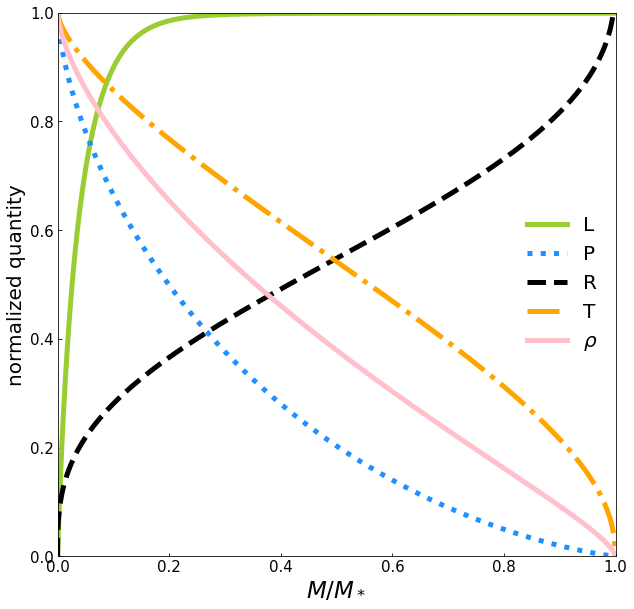

In [283]:
# define mass
M_Msol = 5
M = M_Msol * const.M_sun.cgs.value # stellar mass in cgs unit
M_i = M * 1e-20
M_f = M * 0.999
M_fit = M * 0.6

# composition
X,Y,Z = 0.7,0.26,0.04
mu = 4 / (3 + 5 * X) # ~0.6
fixed_params = [mu, X, Y, Z]

# fit parameter
n_left = int(1e7)
n_right = int(1e7)
grid_log_scale_l = int(1e8)
grid_log_scale_r = int(1e10)

# fitted parameters - P_c, T_c, R, L
# bestfit_params = fit.x * free_params_guess
# bestfit_params = [1e+17,2.7e7,1.5e11,2.4e36]
# bestfit_params = [2.48e+16,2.1e7,2.2e11,4.6e35]
# bestfit_params = [2.48e+16,2.5e7,3.2e11,7.6e35]
bestfit_params = np.array([5.59714e16,#947e16,#10**(16.84),
                           26.45e6,
                           9.3e10,
                           10**3.1*const.L_sun.cgs.value])

bc_core = get_bc_i(bestfit_params,M,M_i,mu,X,Z)
bc_surf = get_bc_f(bestfit_params,M,mu)

# integrate
out = shoot_out(f = lambda y,x: derivs(y,x,fixed_params),
              x_i = M_i,
              x_f = M_f ,
              x_fit = M_fit,
              bc_i_guess = bc_core,
              bc_f_guess = bc_surf,
              return_y = True,
              n_left = n_left,
              n_right = n_right,
              grid_log_scale_l = grid_log_scale_l,
              grid_log_scale_r = grid_log_scale_r)
# out = shootf(f = lambda y,x: derivs(y,x,fixed_params),
#               x_i = M_i,
#               x_f = M_f ,
#               x_fit = M_fit,
#               bc_i_guess = bc_core,
#               bc_f_guess = bc_surf,
#               return_y = True,
#               n_left = n_left,
#               n_right = n_right,
#               grid_log_scale = grid_log_scale_l)

# parse outputs
res, x_sol, y_sol = out
l,p,r,t = y_sol
rho = calc_density(p,t,mu)

#  plot
vals = [l,p,r,t,rho]
colors = ['yellowgreen','dodgerblue','k','orange','pink']
lss = ['-',':','--','-.','-']
labels = ['L','P','R','T',r'$\rho$']
ymax = [*np.nanmax([bc_core,bc_surf],axis=0),rho.max()]

fig,ax = plt.subplots(1,1,figsize=(10,10))
fig.set_facecolor('w')
ds_f = int(len(x_sol)/1000)
for y,_ymax, c,ls,label in zip(vals,ymax,colors,lss,labels):
    xval = x_sol/M
    ax.plot(xval[::ds_f], (y/_ymax)[::ds_f],
                 c=c, ls=ls, lw=5, label=label)
ax.tick_params(direction='in',labelsize=15)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.legend(frameon=False,fontsize=20)
ax.set_xlabel(r'$M/M_*$',fontsize=23)
ax.set_ylabel(r'normalized quantity',fontsize=20)
plt.savefig('fitted_5Msun_X70_Y26_Z04.png',dpi=100,bbox_inches='tight')
plt.show()

## calculate quantities

In [142]:
bestfit_params

array([5.59714000e+16, 2.64500000e+07, 9.30000000e+10, 4.81916648e+36])

In [139]:
l,p,r,t = y_sol
np.array([l.max(),p.max(),r.max(),t.max()])

array([4.81514816e+36, 5.59714000e+16, 9.81282192e+10, 2.64500000e+07])

In [268]:
rho = calc_density(p,t,mu)
eps = calc_eps_total(t,rho,X1=X, XCNO=0.7*Z)
kappa = calc_opacity(np.log10(t),rho)
grad_ad = calc_grad_ad(p,t)
grad_actual = calc_grad_actual(p,t)
grad_rad = calc_grad_rad(p,t,x_sol,l,kappa)

In [272]:
df = pd.DataFrame(columns=['M_frac','L_frac','P_frac','R_frac','T_frac'])
downsample_factor = 1000
df['M_frac'] = (x_sol / M)[::downsample_factor]
df['L_frac'] = (l / l.max())[::downsample_factor]
df['P_frac'] = (p / p.max())[::downsample_factor]
df['R_frac'] = (r / r.max())[::downsample_factor]
df['T_frac'] = (t / t.max())[::downsample_factor]
df['log10(rho)'] = np.log10(rho)[::downsample_factor]
df['log10(eps)'] = np.log10(eps)[::downsample_factor]
df['log10(kappa)'] = np.log10(kappa)[::downsample_factor]
df['grad_rad'] = grad_rad[::downsample_factor]
df['grad_ad'] = grad_ad[::downsample_factor]
df['grad_actual'] = grad_ad[::downsample_factor]
df['conv?'] = (df['grad_ad'] < df['grad_rad']).astype(int)

In [273]:
df.head()

,M_frac,L_frac,P_frac,R_frac,T_frac,log10(rho),log10(eps),log10(kappa),grad_rad,grad_ad,grad_actual,conv?
0,1.000000e-20,3.466597e-19,1.0,1.176421e-07,1.0,1.188317,4.225037,-0.332868,3.517263,0.376726,0.376726,1
1,1.106260e-11,3.834955e-10,1.0,1.216695e-04,1.0,1.188317,4.225037,-0.332868,3.517262,0.376726,0.376726,1
2,2.214559e-11,7.676979e-10,1.0,1.533411e-04,1.0,1.188317,4.225037,-0.332868,3.517262,0.376726,0.376726,1
3,3.324901e-11,1.152609e-09,1.0,1.755857e-04,1.0,1.188317,4.225037,-0.332868,3.517261,0.376726,0.376726,1
4,4.437291e-11,1.538229e-09,1.0,1.933165e-04,1.0,1.188317,4.225037,-0.332868,3.517261,0.376726,0.376726,1


## save data to csv

In [274]:
description = '''# fitted_5Msun_X70_Y26_Z04.csv
# Stellar Structure Calculation
# Yukei S. Murakami @ Johns Hopkins University, May 2023
# 
# A csv file containing calculated stellar structure.
# Values with _frac are reported in the form of fraction. 
# To convert to the physical unit, multiply by the scale values below.
#
###### Physical value scaling:
# mass:        m = M_frac * 5.000 * M_sun = M_frac * 5.000 * 1.988e33 [g]
# luminosity:  l = L_frac * 4.815e36 [erg/s]
# pressure:    p = P_frac * 5.597e16 [dyne/cm2]
# radius:      r = R_frac * 9.813e10 [cm]
# temperature: t = T_frac * 2.645e7  [K]
#
###### Additional quantities (calculated from the result):
# log10(rho): log density log10(rho/[g/cm3])
# log10(eps): log energy generation rate log10(eps/[erg/g])
# log10(kappa): opacity
# grad_rad: radiative gradient
# grad_ad: adiabatic gradient
# grad_actual: actual gradient d(lnT)/d(lnP)
# conv?: 1 (True) if convective, 0 (False) if radiative
# 
# The structure quantities are calculated by minimizing the disagreements 
# at the surface (shoot to the surface).
#
###### Fitted values:
# total luminosity:    L   = 4.819e36 [erg/s]
# central pressure:    P_c = 5.597e16 [dyne/cm2]
# photosphere radius:  R   = 9.3e10   [cm]
# central temperature: T_c = 2.645e7  [K]
# 
# Additional parameters used for the calculation are available below:
# 
###### Fixed values:
# abundances: X = 0.700
#             Y = 0.260
#             Z = 0.040
# molecular weight: mu = 0.615
# inner mass fraction: M_i_frac = 1e-20
# outer mass fraction: M_f_frac = 0.999
# coordinate of fitpoint(*): M_fit_frac = 0.6
# 
#
# (*) since shoot-to-fit method failed for this calculation,
#     this value is only used as the coordinate of the 
#     largest-spacing of the mass-shell grid.
#
'''
    
with open('fitted_5Msun_X70_Y26_Z04.csv', 'a') as f:

    f.write(description)
    df.to_csv(f,float_format='%.3e',index=False )

# plots

## gridpoints

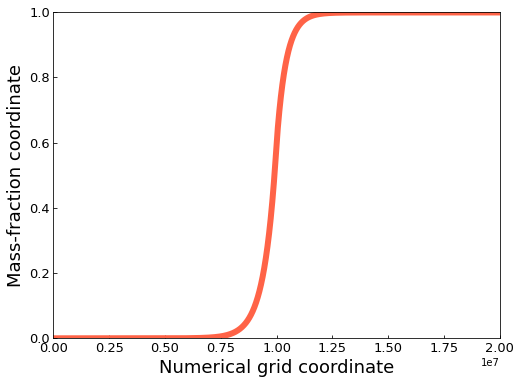

In [196]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
fig.set_facecolor('w')
ax.tick_params(direction='in',labelsize=13)
plt.plot(np.arange(xval.shape[0])[::1000],xval[::1000],c='tomato',lw=6)
plt.xlim(0,xval.shape[0])
plt.ylim(0,1)
plt.xlabel('Numerical grid coordinate',fontsize=18)
plt.ylabel('Mass-fraction coordinate',fontsize=18)
plt.savefig('gridpoint_map.pdf',bbox_inches='tight')

## gradient

In [207]:
# calculate gradients
del_ad = calc_grad_ad(p,t)
opacity = calc_opacity(np.log10(t),rho)
del_rad = calc_grad_rad(p,t,x_sol,l,opacity)
del_actual = np.gradient(np.log(t),np.log(p))

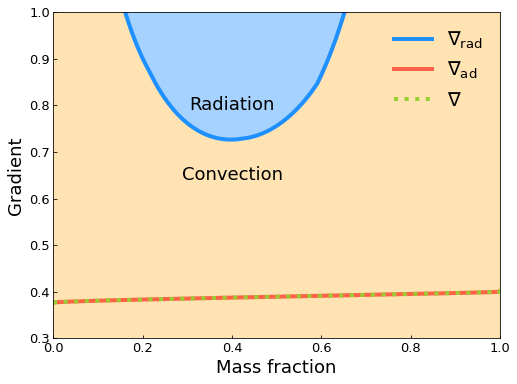

In [282]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
fig.set_facecolor('w')
ax.tick_params(direction='in',labelsize=13)
plt.plot(xval[::1000],del_rad[::1000],c='dodgerblue',lw=4,
        label=r'$\nabla_\mathrm{rad}$')
plt.plot(xval[::1000],del_ad[::1000],c='tomato',lw=4,
         label=r'$\nabla_\mathrm{ad}$')
plt.plot(xval[::1000],del_actual[::1000],c='yellowgreen',ls=':',lw=4,
        label=r'$\nabla$')


plt.fill_between(xval[::1000],del_rad[::1000],2,
                 color='dodgerblue',alpha=0.4,rasterized=True)
plt.fill_between(xval[::1000],0,del_rad[::1000],
                 color='orange',alpha=0.3,rasterized=True)
ax.text(0.4,0.8,'Radiation',va='center',ha='center',fontsize=18)
ax.text(0.4,0.65,'Convection',va='center',ha='center',fontsize=18)
plt.legend(frameon=False,fontsize=19)
plt.xlim(0,1)
plt.ylim(0.3,1)
plt.xlabel('Mass fraction',fontsize=18)
plt.ylabel('Gradient',fontsize=18)
plt.savefig('gradient.pdf',bbox_inches='tight')

## opacity

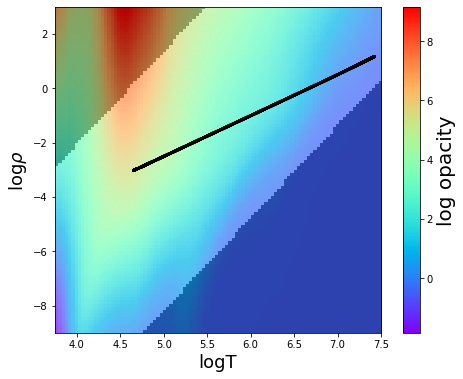

In [248]:
logrho_th = np.linspace(-9,3,100)
logT_th = np.linspace(3.75,7.5,100)
xx,yy = np.meshgrid(logT_th,logrho_th)


fig,ax = plt.subplots(1,1,figsize=(8,6))
fig.set_facecolor('w')

# extrapolate
log_opacity = np.log10(calc_opacity(xx,10**yy))
im = ax.imshow(log_opacity.T,origin='lower',
           extent=([3.75,7.5,-9,3]),
           aspect=(7.5-3.75)/(9+3),
           cmap = 'rainbow',alpha=1.0)

# overlay the region of extrapolation
log_opacity = np.log10(calc_opacity(xx,10**yy,
                                    extrapolate=False))
edge_map = np.isfinite(log_opacity)
ax.imshow(edge_map,origin='lower',
           extent=([3.75,7.5,-9,3]),
           aspect=(7.5-3.75)/(9+3),
           cmap = 'gray',
           alpha=0.3)

ax.set_xlabel('logT',fontsize=18)
ax.set_ylabel(r'log$\rho$',fontsize=18)
cb = fig.colorbar(im)
cb.ax.set_ylabel('log opacity',x=1.3,fontsize=20)

ax.scatter(np.log10(t[::100]),np.log10(rho[::100]),s=1,alpha=0.1,c='k',
          rasterized=True)
plt.savefig('opacity_heatmap.pdf',bbox_inches='tight')

# Tests

## energy generation rate (SI textbook figure)

(-5.0, 5.0)

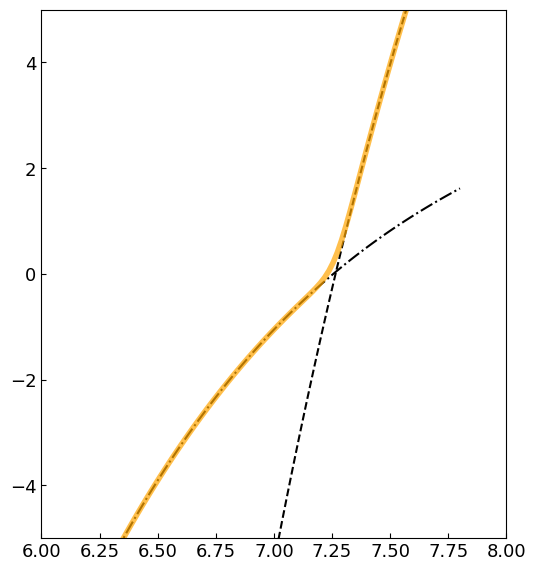

In [282]:
rho = 1
X1 = 1
T_th = 10**np.linspace(6.,7.8,100)

eps_pp = calc_eps_pp(T_th,rho,X1)
epx_CNO = calc_eps_CNO(T_th,rho,X1,XCNO=0.01)

fig,ax = plt.subplots(1,1,figsize=(6,7),dpi=100)
fig.set_facecolor('w')
ax.tick_params(direction='in',labelsize=13)
plt.plot(np.log10(T_th),np.log10(eps_pp),c='k',ls='-.')
plt.plot(np.log10(T_th),np.log10(epx_CNO),c='k',ls='--')
plt.plot(np.log10(T_th),np.log10(eps_pp+epx_CNO),c='orange',ls='-',lw=4,alpha=0.7)

plt.xlim(6,8)
plt.ylim(-5,5)

## solver & shootf test/prototype

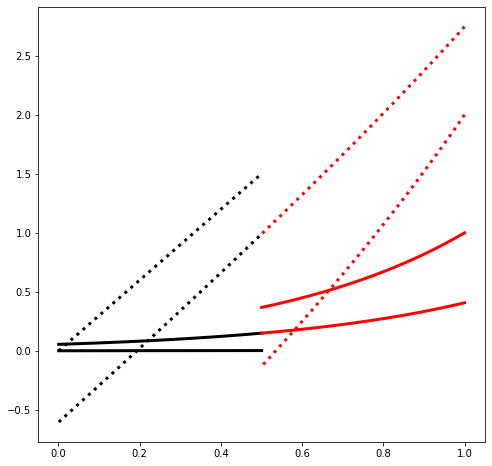

In [178]:

######
# TEST
######
x_i = 1e-3
x_f = 1

bc_i_guess = [1e-3,1e-3]
bc_f_guess = [1.0,2.0]
bc_initial_guesses = [*bc_i_guess,*bc_f_guess]
Nparams = 2

# define differential equation
def derivs(y,x):
    # y' = ay
    a = 2
    b = 3
    return [a*y[0],a*y[0]+b]


# check the best-fit values
out = shootf(f = derivs,
              x_i = x_i,
              x_f = x_f,
              bc_i_guess = bc_i_guess,
              bc_f_guess = bc_f_guess,
              return_y = True)
res, x_left, x_right, y_left,y_right = out

fig = plt.figure(figsize=(8,8))
ls = ['-',':']
for i in range(2):
    plt.plot(x_left,y_left[:,i],c='k',ls=ls[i],lw=3)
    plt.plot(x_right,y_right[:,i],c='r',ls=ls[i],lw=3)



# define a helper function that returns the value to be minimized
def minimize_helper(params):
    bc_i = params[:Nparams]
    bc_f = params[Nparams:]
    res = shootf(f = derivs,
                  x_i = x_i,
                  x_f = x_f,
                  bc_i_guess = bc_i,
                  bc_f_guess = bc_f,
                  return_y = False)
    return np.sum(np.abs(res))

# minimize
fit = minimize(minimize_helper,x0 = bc_initial_guesses)

# check the best-fit values
out = shootf(f = derivs,
              x_i = x_i,
              x_f = x_f,
              bc_i_guess = fit.x[:Nparams],
              bc_f_guess = fit.x[Nparams:],
              return_y = True)
res, x_left, x_right, y_left,y_right = out

ls = ['-',':']
for i in range(2):
    plt.plot(x_left,y_left[:,i],c='k',ls=ls[i],lw=3)
    plt.plot(x_right,y_right[:,i],c='r',ls=ls[i],lw=3)

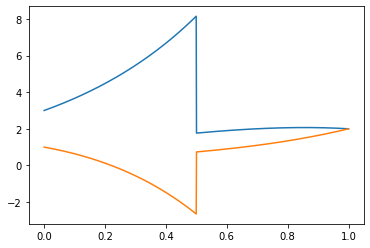

In [101]:
def derivs_test(y,x):
    # y' = ay
    a = 2
    b = 3
    return [a*y[0],-a*y[0]+b]


out = shootf(derivs_test,0,1,
             bc_i_guess = [3,1],
             bc_f_guess = [2,2],
             return_y=True)
res,x,y = out
plt.plot(x,y[0])
plt.plot(x,y[1])